Adaptivity
===

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry

Define a geometry by curves:

In [2]:
#   point numbers 0, 1, ... 11
#   sub-domain numbers (1), (2), (3)
#  
#
#             7-------------6
#             |             |
#             |     (2)     |
#             |             |
#      3------4-------------5------2
#      |                           |
#      |             11            |
#      |           /   \           |
#      |         10 (3) 9          |
#      |           \   /     (1)   |
#      |             8             |
#      |                           |
#      0---------------------------1
#

def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, left-domain, right-domain:
    lines = [ (0,1,"bot",1,0), (1,2,"outer",1,0), (2,5,"outer",1,0), (5,4,"inner",1,2), (4,3,"outer",1,0), (3,0,"outer",1,0), \
              (5,6,"outer",2,0), (6,7,"outer",2,0), (7,4,"outer",2,0), \
              (8,9,"inner",3,1), (9,10,"inner",3,1), (10,11,"inner",3,1), (11,8,"inner",3,1) ]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append(["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)

    geometry.SetMaterial(1,"base")
    geometry.SetMaterial(2,"top")    
    geometry.SetMaterial(3,"chip")

    return geometry

geo = MakeGeometry()
# Draw(geo)

Piece-wise constant coefficients in sub-domains:

In [5]:
mesh = Mesh(geo.GenerateMesh(maxh=0.2))

fes = H1(mesh, order=3, dirichlet="bot", autoupdate=True)
u, v = fes.TnT()

lam = CoefficientFunction([1, 1000, 10])
a = BilinearForm(fes)
a += lam*grad(u)*grad(v)*dx

# heat-source in inner subdomain
f = LinearForm(fes)
f += 1*v*dx(definedon="chip")

c = Preconditioner(a, type="multigrid", inverse="sparsecholesky")

gfu = GridFunction(fes, autoupdate=True)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2004-172-gaa6a466d', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

Assemble and solve problem:

In [9]:
def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    
SolveBVP()
Draw (gfu, mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2004-172-gaa6a466d', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

Gradient recovery error estimator: Interpolate finite element flux 

$$
q_h := I_h (\lambda \nabla u_h)
$$

and take difference as element error indicator:

$$
\eta_T := \tfrac{1}{\lambda} \| q_h - \lambda \nabla u_h \|_{L_2(T)}^2
$$

In [10]:
l = []    # l = list of estimated total error
space_flux = HDiv(mesh, order=2, autoupdate=True)
gf_flux = GridFunction(space_flux, "flux", autoupdate=True)

def CalcError():
    
    # FEM-flux 
    flux = lam * grad(gfu)        
    # interpolate into H(div)
    gf_flux.Set(flux) 
    
    # compute estimator:
    err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
    eta2 = Integrate(err, mesh, VOL, element_wise=True)
    l.append ((fes.ndof, sqrt(sum(eta2))))
    print("ndof =", fes.ndof, " toterr =", sqrt(sum(eta2)))
    
    # mark for refinement:
    maxerr = max(eta2)
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)
        
CalcError()

ndof = 208  toterr = 0.004786183577239572


Adaptive loop:

In [11]:
level = 0
while fes.ndof < 50000:  
    mesh.Refine()
    SolveBVP()
    CalcError()
    level = level+1
    if level%5 == 0:
        Draw (gfu)

ndof = 454  toterr = 0.0036081508491326592
ndof = 547  toterr = 0.0029864085613298666
ndof = 1168  toterr = 0.002012459176872626
ndof = 1984  toterr = 0.0012753055579932137
ndof = 2890  toterr = 0.0007999943134521744


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2004-172-gaa6a466d', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

ndof = 3760  toterr = 0.0005088041990869606
ndof = 4567  toterr = 0.0003319535330960255
ndof = 5176  toterr = 0.00023705580873545394
ndof = 5821  toterr = 0.00017331742431524227
ndof = 6493  toterr = 0.00012667678504653425


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2004-172-gaa6a466d', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

ndof = 7120  toterr = 0.00010246756794705633
ndof = 7828  toterr = 7.662553021200827e-05
ndof = 8623  toterr = 6.105228957013482e-05
ndof = 9478  toterr = 4.671758083710444e-05
ndof = 10426  toterr = 3.6787057506488624e-05


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2004-172-gaa6a466d', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

ndof = 11533  toterr = 2.9159799090073276e-05
ndof = 12796  toterr = 2.407904653290273e-05
ndof = 14356  toterr = 1.9087808437226768e-05
ndof = 16321  toterr = 1.5036749761471703e-05
ndof = 18976  toterr = 1.1511866941392251e-05


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2004-172-gaa6a466d', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

ndof = 21676  toterr = 9.04323859206414e-06
ndof = 25231  toterr = 6.84304253570657e-06
ndof = 28792  toterr = 5.400326682439814e-06
ndof = 33070  toterr = 4.250477494346375e-06
ndof = 39082  toterr = 3.2304065705009077e-06


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2004-172-gaa6a466d', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

ndof = 45721  toterr = 2.4614876722400765e-06
ndof = 52705  toterr = 1.936696258630429e-06


In [12]:
Draw (gfu)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2004-172-gaa6a466d', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

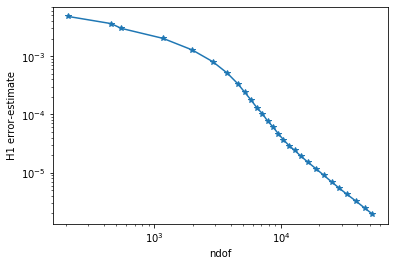

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("H1 error-estimate")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")

plt.ion()
plt.show();